In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from more_itertools import sliced
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [107]:
df=pd.read_csv('US_Accidents_March23_sampled_500k.csv')
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [108]:
null_percentages = (df.isnull().sum() / len(df)) * 100
null_percentages.sort_values(ascending=False)

End_Lat                  44.0754
End_Lng                  44.0754
Precipitation(in)        28.5232
Wind_Chill(F)            25.8034
Wind_Speed(mph)           7.3974
Visibility(mi)            2.2582
Wind_Direction            2.2394
Humidity(%)               2.2260
Weather_Condition         2.2202
Temperature(F)            2.0932
Pressure(in)              1.7856
Weather_Timestamp         1.5348
Nautical_Twilight         0.2966
Civil_Twilight            0.2966
Sunrise_Sunset            0.2966
Astronomical_Twilight     0.2966
Airport_Code              0.2892
Street                    0.1382
Timezone                  0.1014
Zipcode                   0.0232
City                      0.0038
Description               0.0002
Traffic_Signal            0.0000
Roundabout                0.0000
Station                   0.0000
Stop                      0.0000
Traffic_Calming           0.0000
Country                   0.0000
Turning_Loop              0.0000
No_Exit                   0.0000
End_Time  

**Eliminate columns exhibiting a high count of NULL values and exclude consistently uniform data to prevent potential bias in the analysis.**

In [109]:
columns_to_drop = ['End_Lat', 'End_Lng', 'Precipitation(in)', 'Wind_Chill(F)','ID']
df1 = df.drop(columns=columns_to_drop)
constant_columns = df.columns[df.nunique() == 1]
df1 = df1.drop(columns=constant_columns)
df1=df1.dropna()

In [110]:
df1.columns

Index(['Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [111]:
df1=df1[['Severity', 'Start_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)','Wind_Speed(mph)', 'Weather_Condition',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Signal',
       'Sunrise_Sunset']]

**Fetching the hour when accident occured**

In [112]:
df1['Start_Time'] = pd.to_datetime(df1['Start_Time'].str[:19], format='%Y-%m-%d %H:%M:%S')
df1['Hour'] = df1['Start_Time'].dt.hour
df1 = df1.drop(columns=['Start_Time'])

In [113]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456181 entries, 0 to 499999
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           456181 non-null  int64  
 1   Start_Lat          456181 non-null  float64
 2   Start_Lng          456181 non-null  float64
 3   Distance(mi)       456181 non-null  float64
 4   Description        456181 non-null  object 
 5   Temperature(F)     456181 non-null  float64
 6   Humidity(%)        456181 non-null  float64
 7   Pressure(in)       456181 non-null  float64
 8   Visibility(mi)     456181 non-null  float64
 9   Wind_Speed(mph)    456181 non-null  float64
 10  Weather_Condition  456181 non-null  object 
 11  Bump               456181 non-null  bool   
 12  Crossing           456181 non-null  bool   
 13  Give_Way           456181 non-null  bool   
 14  Junction           456181 non-null  bool   
 15  No_Exit            456181 non-null  bool   
 16  Railway

**The description includes almost all major important features, but a few, like 'Distance(mi)' and 'Hour' are missing. The 'Hour' feature, extracted from the time stamps of the start time, has been incorporated into the description.**

In [114]:
df1['Merged_Description'] = df1['Description'] + ' Distance: ' + df1['Distance(mi)'].astype(str) + ' Hour: ' + df1['Hour'].astype(str)
df1 = df1.drop(['Description', 'Distance(mi)', 'Hour'], axis=1)
train_df = df1[['Merged_Description','Severity']].sample(n=4000, random_state=10)
print(df['Severity'].value_counts())
train_df.head()

Severity
2    398142
3     84520
4     13064
1      4274
Name: count, dtype: int64


,Merged_Description,Severity
396945,Incident on CASA LOMA AVE near YORBA LINDA BLV...,2
467902,Accident on County Hwy-J9 French Camp Rd at Co...,2
265411,Stationary traffic on FL-913 from Rickenbacker...,2
361980,At Broadway/Park Place Blvd/Exit 39 - Accident...,3
459896,At 1st Ave/Exit 47 - Accident. Distance: 0.187...,2


In [103]:
df1['Tokenized_Description'] = df1['Merged_Description'].apply(text_to_word_sequence)
max_words = df1['Tokenized_Description'].apply(len).max()
print("Maximum number of words: ",max_words)
# Set the maximum number of words and sequence length

MAX_VOCABULARY_SIZE = 150
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 150

# Create a tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCABULARY_SIZE, filters='!"#$%&()*+,-./;<=>?@[\]^_`{|}~', lower=True)

# Fit the tokenizer on the 'Merged_Description' column
tokenizer.fit_on_texts(train_df['Merged_Description'].values)

# Get the word index
word_index = tokenizer.word_index

# Print the number of unique tokens
num_unique_tokens = len(word_index)
print(f'Found {num_unique_tokens} unique tokens.')

# Convert text to sequences using the tokenizer
sequences = tokenizer.texts_to_sequences(train_df['Merged_Description'].values)

# Pad sequences to ensure consistent length
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

# Convert severity labels to one-hot encoded format
Y = pd.get_dummies(train_df['Severity']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Maximum number of words:  116
Found 5377 unique tokens.
Shape of data tensor: (4000, 500)
Shape of label tensor: (4000, 4)
(3400, 500) (3400, 4)
(600, 500) (600, 4)


**The target variable "Severity" exhibited a significant imbalance, with a descending order of counts: 1 being the lowest, followed by 2, 3, and 4. Therefore, assigned weights in the same order, treating 2 and 3 as equal.**

In [89]:
model = Sequential()
model.add(Embedding(MAX_VOCABULARY_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 30
batch_size = 128
class_weights = {0: 3, 1: 1, 2: 1, 3: 2} 
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, class_weight=class_weights, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0005)])

Epoch 1/30
24/24 [==============================] - 42s 2s/step - loss: 0.9378 - accuracy: 0.7742 - val_loss: 0.5766 - val_accuracy: 0.8000
Epoch 2/30
24/24 [==============================] - 37s 2s/step - loss: 0.7183 - accuracy: 0.7967 - val_loss: 0.4665 - val_accuracy: 0.8088
Epoch 3/30
24/24 [==============================] - 37s 2s/step - loss: 0.5648 - accuracy: 0.8461 - val_loss: 0.3667 - val_accuracy: 0.8647
Epoch 4/30
24/24 [==============================] - 38s 2s/step - loss: 0.4588 - accuracy: 0.8784 - val_loss: 0.3027 - val_accuracy: 0.9147
Epoch 5/30
24/24 [==============================] - 37s 2s/step - loss: 0.3860 - accuracy: 0.8941 - val_loss: 0.2954 - val_accuracy: 0.8941
Epoch 6/30
24/24 [==============================] - 38s 2s/step - loss: 0.3607 - accuracy: 0.9065 - val_loss: 0.2860 - val_accuracy: 0.9118
Epoch 7/30
24/24 [==============================] - 37s 2s/step - loss: 0.3237 - accuracy: 0.9108 - val_loss: 0.2619 - val_accuracy: 0.9088
Epoch 8/30
24/24 [==

In [90]:
loss, accuracy= model.evaluate(X_test,Y_test)
print(f'Test Loss: {loss:.2f}, Test Accuracy: {accuracy:.2f}')

19/19 [==============================] - 2s 99ms/step - loss: 0.4266 - accuracy: 0.8717
Test Loss: 0.43, Test Accuracy: 0.87


In [91]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

print(classification_report(Y_true_classes, Y_pred_classes))

19/19 [==============================] - 2s 98ms/step
              precision    recall  f1-score   support

           0       0.33      0.18      0.24        11
           1       0.89      0.96      0.92       464
           2       0.81      0.64      0.71       102
           3       0.91      0.43      0.59        23

    accuracy                           0.87       600
   macro avg       0.74      0.55      0.62       600
weighted avg       0.86      0.87      0.86       600



In [92]:
model.save_weights('model_weights.h5')
model.save('model.h5')

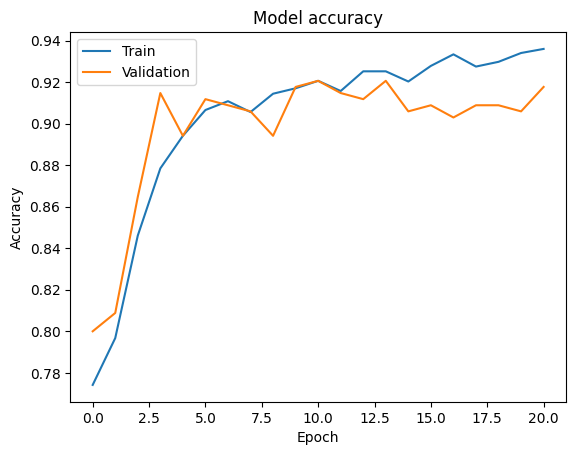

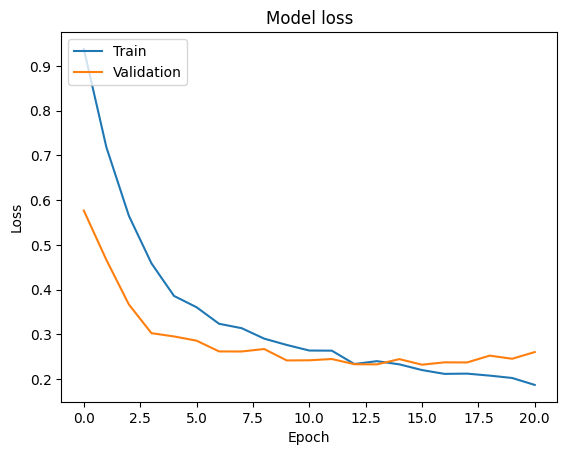

In [93]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()